## R Notebook for Visualizing Mothur Output with R Package Phyloseq

In [2]:
library(ggplot2)
library(vegan)
library(dplyr)
library(scales)
library(grid)
library(reshape2)
library(phyloseq)

Warning message:
"package 'vegan' was built under R version 3.5.2"Loading required package: permute
Warning message:
"package 'permute' was built under R version 3.5.2"Loading required package: lattice
This is vegan 2.5-4

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'phyloseq' was built under R version 3.5.2"

## Import Data from mothur

In [3]:
paired = readline(prompt = "Is your data paired (Y/N)?")

Is your data paired (Y/N)?Y


In [3]:
workingDir = "C:/Users/Haley/Documents/MiSeq/MiSeq_SOP/H1-7_Output"
setwd(workingDir)
sharedfile = "stability.trim.contigs.good.unique.good.filter.unique.precluster.pick.pick.opti_mcc.shared"
taxfile = "stability.trim.contigs.good.unique.good.filter.unique.precluster.pick.pick.opti_mcc.0.03.cons.taxonomy"
mapfile = "Sample_Data.csv"
theme_set(theme_bw())

In [4]:
mothur_data <- import_mothur(mothur_shared_file = sharedfile,
                             mothur_constaxonomy_file = taxfile)
map <- read.csv(mapfile)
map <- sample_data(map)
rownames(map) <- map$Sample

moth_merge <- merge_phyloseq(mothur_data, map)

colnames(tax_table(moth_merge)) <- c("Kingdom", "Phylum", "Class", "Order", 
                                      "Family", "Genus")
Kingdom = c("Bacteria", "Archaea")
scorps <- moth_merge %>%
  subset_taxa(
    Kingdom == Kingdom &
      Family  != "mitochondria" &
      Class   != "Chloroplast"
  )

## Distribution of Reads

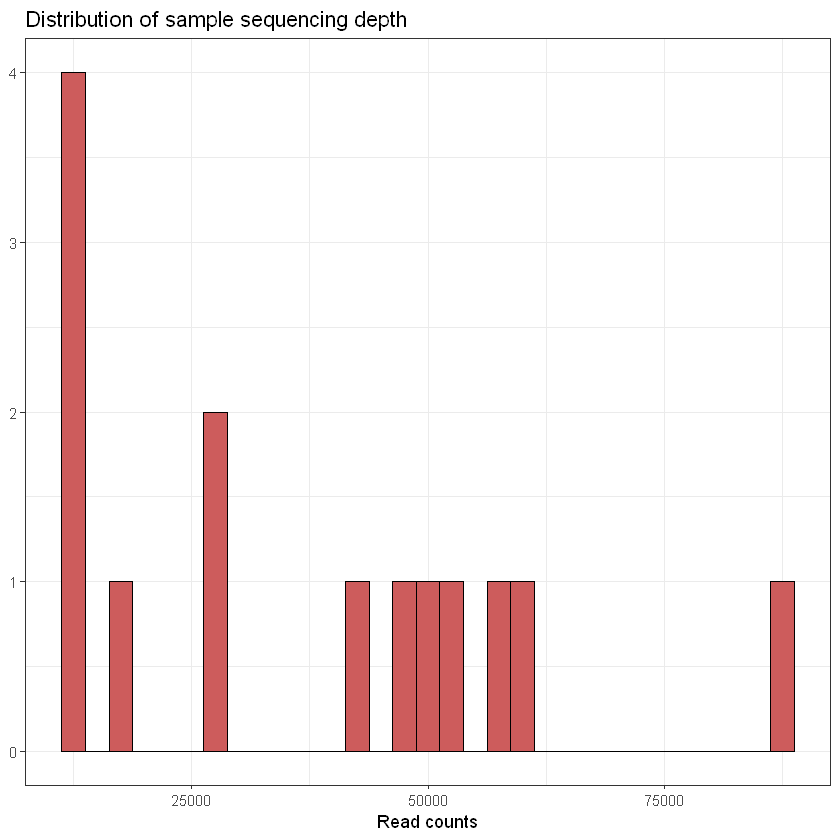

In [5]:
sample_sum_df <- data.frame(sum = sample_sums(scorps))
ggplot(sample_sum_df, aes(x = sum)) + 
  geom_histogram(color = "black", fill = "indianred", binwidth = 2500) +
  ggtitle("Distribution of sample sequencing depth") + 
  xlab("Read counts") +
  theme(axis.title.y = element_blank())


## Stacked Barplots of Composition of Phyla In Communities

Set percent cutoff for relative abundance of phyla included in barplots

In [18]:
cutoff = 0.005

Warning message in psmelt(.):
"The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names."

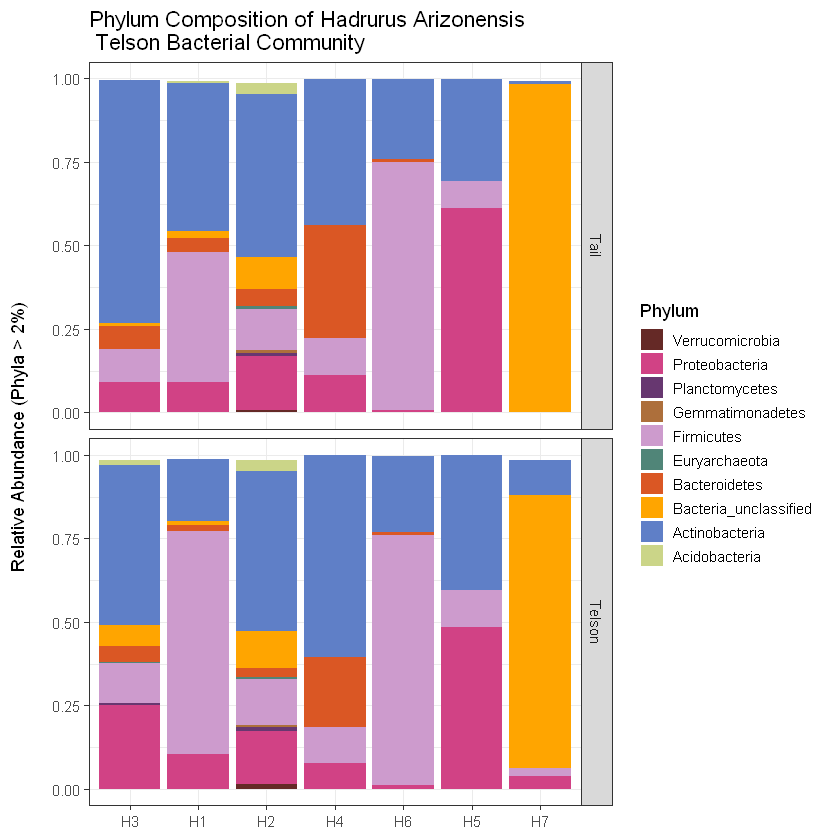

In [19]:
scorps_phylum <- scorps %>%
  tax_glom(taxrank = "Phylum") %>%                     # agglomerate at phylum level
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt() %>%                                         # Melt to long format
  filter(Abundance > cutoff) %>%                         # Filter out low abundance taxa
  arrange(Phylum)                                      # Sort data frame alphabetically by phylum

s <- strsplit(scorps_phylum$Sample, "ARIZON")
s <- sapply(s, function(x)x[1])

scorps_phylum <- scorps_phylum %>% mutate(sample2 = s)


phylum_colors <- c(
  "#CBD588", "#5F7FC7", "orange","#DA5724", "#508578", "#CD9BCD",
  "#AD6F3B", "#673770","#D14285", "#652926", "#C84248", 
  "#8569D5", "#5E738F","#D1A33D", "#8A7C64", "#599861"
)



ggplot(scorps_phylum, aes(x = sample2, y = Abundance, fill = Phylum)) + 
  facet_grid(Type~.) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = phylum_colors) +
  scale_x_discrete(
    drop = FALSE,
    labels = unique(scorps_phylum$sample2)
  ) +
  # Remove x axis title
  theme(axis.title.x = element_blank()) + 
  #
  guides(fill = guide_legend(reverse = TRUE, keywidth = 1, keyheight = 1)) +
  ylab("Relative Abundance (Phyla > 2%) \n") +
  ggtitle("Phylum Composition of Hadrurus Arizonensis \n Telson Bacterial Community") 



Function to Scale Reads

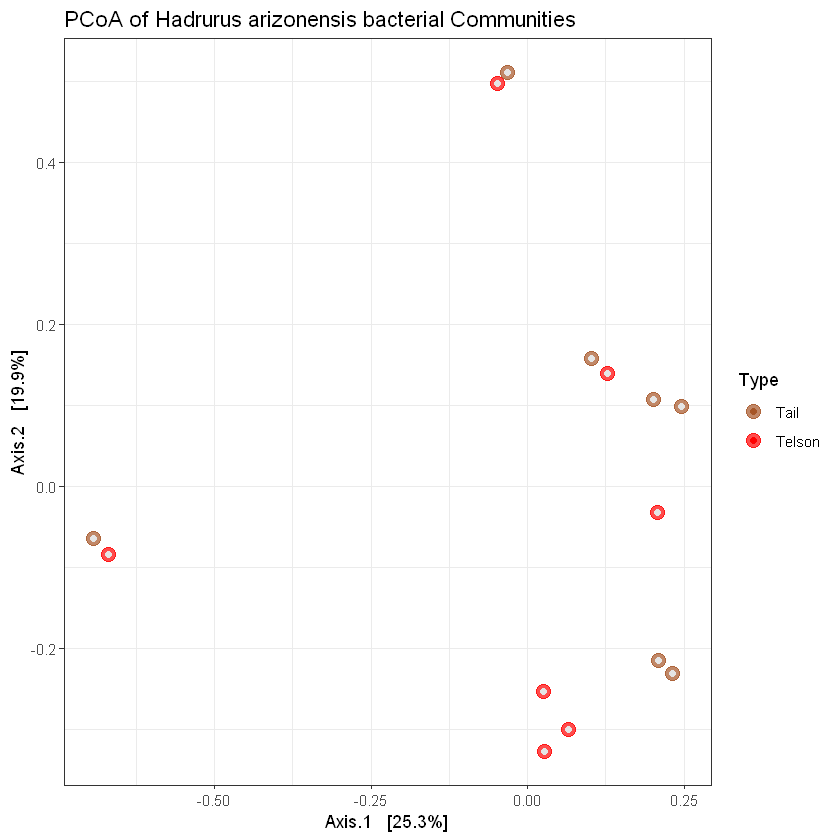

In [8]:
scale_reads <- function(physeq, n=1) {
  scale2 <- function(x) {
    #cat("in scale2..\n")
    (100 * x/sum(x))
  }
  physeq.scale <- transform_sample_counts(physeq, scale2)
  otu_table(physeq.scale) <- floor(otu_table(physeq.scale))
  physeq.scale <- prune_taxa(taxa_sums(physeq.scale) > 0, physeq.scale)
  return(physeq.scale)
}


scorps_scale <- scorps %>% scale_reads 

scorps_pcoa <- ordinate(
  physeq = scorps_scale, 
  method = "PCoA", 
  distance = "bray"
)


plot_ordination(
  physeq = scorps_scale,
  ordination = scorps_pcoa,
  color = "Type",
  title = "PCoA of Hadrurus arizonensis bacterial Communities"
) + 
  scale_color_manual(values = c("#a65628", "red", "#ffae19",
                                "#4daf4a", "#1919ff", "darkorchid3", "magenta")
  ) +
  geom_point(aes(color = Type), alpha = 0.7, size = 4) +
  geom_point(colour = "grey90", size = 1.5) 

Function to run adonis test on a physeq object and a variable from metadata

In [10]:
doadonis <- function(physeq, category) {
  physeq.scale <- scale_reads(physeq, min(sample_sums(physeq)))
  bdist <- phyloseq::distance(physeq.scale, "bray")
  col <- as(sample_data(physeq), "data.frame")[ ,category]
  
  # Adonis test
  adonis.bdist <- adonis(bdist ~ col)
  print("Adonis results:")
  print(adonis.bdist)
  
  # Homogeneity of dispersion test
  betatax = betadisper(bdist,col)
  p = permutest(betatax)
  print("Betadisper results:")
  print(p$tab)
}

## Permanova

In [11]:
set.seed(1)

# Calculate bray curtis distance matrix
scorps_bray <- phyloseq::distance(scorps, method = "bray")

# make a data frame from the sample_data
sampledf <- data.frame(sample_data(scorps))

# Adonis test
adonis(scorps_bray ~ Type, data = sampledf)


Call:
adonis(formula = scorps_bray ~ Type, data = sampledf) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
Type       1    0.2788 0.27885 0.74407 0.05839  0.789
Residuals 12    4.4971 0.37476         0.94161       
Total     13    4.7759                 1.00000       

## Alpha Diversity

In [12]:
min_lib <- min(sample_sums(scorps))
nsamp = nsamples(scorps)
trials = 100
richness <- matrix(nrow = nsamp, ncol = trials)
row.names(richness) <- sample_names(scorps)

evenness <- matrix(nrow = nsamp, ncol = trials)
row.names(evenness) <- sample_names(scorps)

set.seed(3)

for (i in 1:100) {
  # Subsample
  r <- rarefy_even_depth(scorps, sample.size = min_lib, verbose = FALSE, replace = TRUE)
  
  # Calculate richness
  rich <- as.numeric(as.matrix(estimate_richness(r, measures = "Observed")))
  richness[ ,i] <- rich
  
  # Calculate evenness
  even <- as.numeric(as.matrix(estimate_richness(r, measures = "InvSimpson")))
  evenness[ ,i] <- even
}

Create a new dataframe to hold the means and standard deviations of richness estimates

In [13]:
Sample <- row.names(richness)
mean <- apply(richness, 1, mean)
sd <- apply(richness, 1, sd)
measure <- rep("Richness", nsamp)
rich_stats <- data.frame(Sample, mean, sd, measure)

Create a new dataframe to hold the means and standard deviations of evenness estimates

In [14]:
Sample <- row.names(evenness)
mean <- apply(evenness, 1, mean)
sd <- apply(evenness, 1, sd)
measure <- rep("Inverse Simpson", nsamp)
even_stats <- data.frame(Sample, mean, sd, measure)

Combine estimates for richness and evenness into one dataframe

In [15]:
alpha <- rbind(rich_stats, even_stats)

Add the sample metadata into this dataframe

In [16]:
s <- data.frame(sample_data(scorps))
alphadiv <- merge(alpha, s, by = "Sample") 

## Plot the two alpha diversity measures

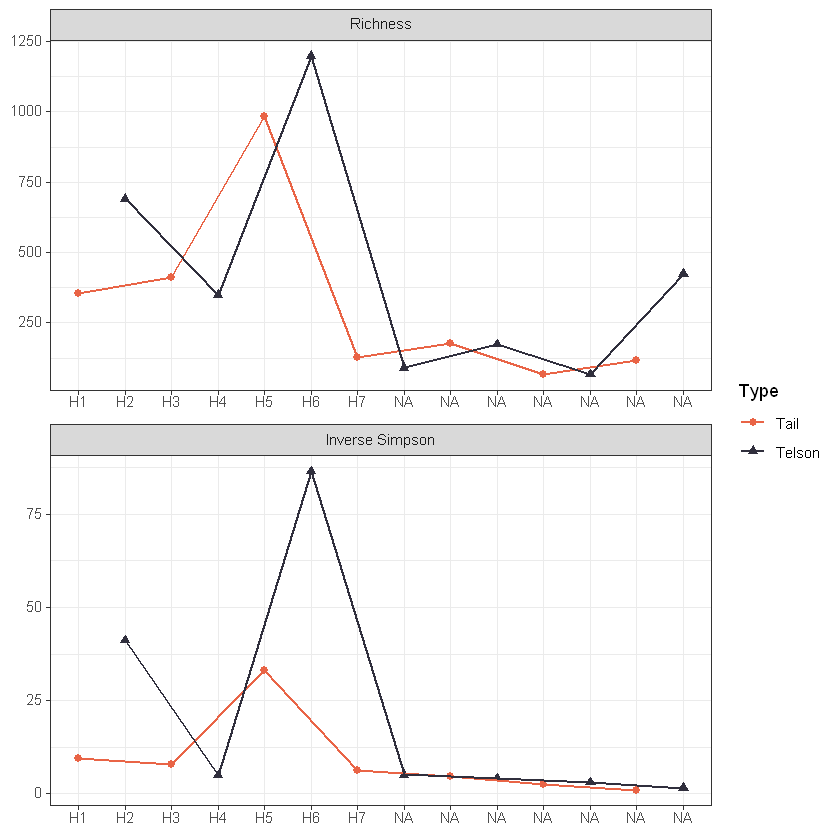

In [17]:
ggplot(alphadiv, aes(x = Sample, y = mean, color = Type, group = Type, shape = Type)) +
  geom_point(size = 2) + 
  geom_line(size = 0.8) +
  facet_wrap(~measure, ncol = 1, scales = "free") +
  scale_color_manual(values = c("#E96446", "#302F3D", "#87CEFA")) +
  scale_x_discrete(
   
    labels = c("H1","H2","H3","H4","H5","H6","H7"),
    drop = FALSE
  ) +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank()
  )
